In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import regularizers

In [2]:
# Import required libraries
os.chdir(r'C:\Users\Eric\Desktop\Cal Poly Pomona\Spring 2024\CS 4210')

# Store data, labels in the list
data = []
labels = []

# Classes: 0 - Red, 1 - Green, 2 - Yellow
classes = 3
cur_path = os.getcwd()

In [3]:
# Preprocess the images
for i, color in enumerate(['red', 'green', 'yellow']):
    path = os.path.join(cur_path, 'train_1', color)  # Path to the color subdirectory
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))  # Use os.path.join for robust path construction
            image = image.resize((30,30))
            image = np.array(image)
            if image.shape == (30, 30, 3):  # Ensure all images have the same shape
                data.append(image)
                labels.append(i)  # Use the index i as the label
            else:
                print(f"Ignoring image '{a}' in directory '{color}' due to shape mismatch.")
        except Exception as e:
            print(e)

Ignoring image 'yellow_61.png' in directory 'yellow' due to shape mismatch.
Ignoring image 'yellow_62.png' in directory 'yellow' due to shape mismatch.


In [4]:
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure the directory exists before saving data
save_dir = './training/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
# Save Labels & Data for future use
np.save(os.path.join(save_dir, 'data'), data)
np.save(os.path.join(save_dir, 'target'), labels)

# Load data & Labels
data = np.load('./training/data.npy')
labels = np.load('./training/target.npy')
print(data.shape, labels.shape)

(4498, 30, 30, 3) (4498,)


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

(3598, 30, 30, 3) (900, 30, 30, 3) (3598,) (900,)


In [7]:
# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * np.exp(-0.1 * (epoch - 10))

In [8]:
# Build the ANN model with regularization, batch normalization, and learning rate scheduling
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))  # Flatten the input images
# Dense layers with regularization and batch normalization
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(classes, activation='softmax'))  # Output layer with softmax activation

# Compilation of the model with early stopping and learning rate scheduling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop, lr_scheduler])


Epoch 1/20


c:\Users\Eric\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6884 - loss: 1.1645 - val_accuracy: 0.9389 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9043 - loss: 0.6305 - val_accuracy: 0.9633 - val_loss: 0.4433 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9329 - loss: 0.5177 - val_accuracy: 0.9756 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9374 - loss: 0.4820 - val_accuracy: 0.9844 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9401 - loss: 0.4634 - val_accuracy: 0.9767 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9483 - loss: 0.4139 - val_accuracy: 0.9633 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 0.3865 - val_accurac

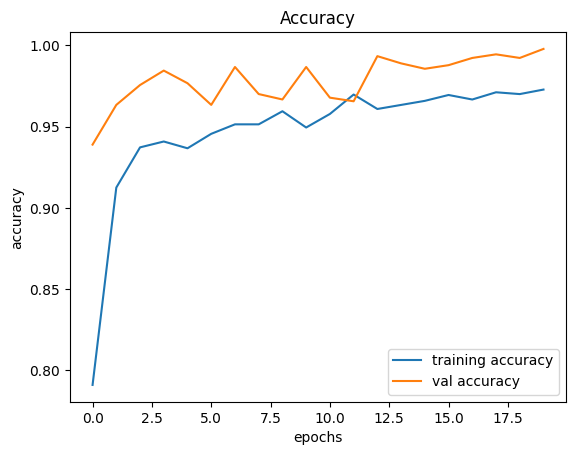

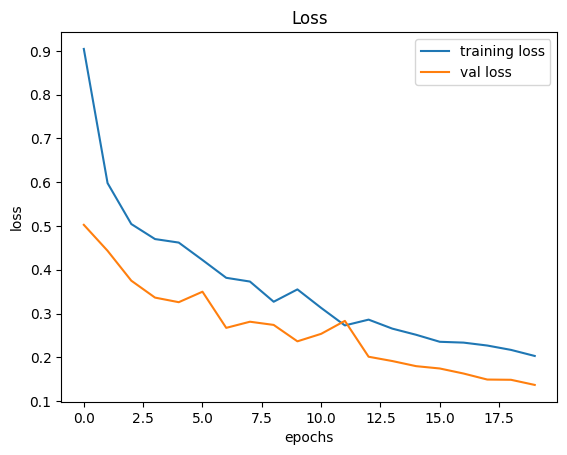

In [9]:
# Accuracy plot
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [24]:
# Save the model
model.save("./training/Traffic_Light_Detector_ANN.h5")